# Model Evaluation

Model evaluation is a crucial step to validate how well the trained model performs to the data that have not seen before.

Load the Breast Cancer dataset and preprocess it. You can download the dataset from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/).

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
x = df.iloc[:, 2:].to_numpy()
y = df.iloc[:, 1].to_numpy()
le = LabelEncoder()
y = le.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

# Pipeline Class

Pipeline class API in scikit-learn allows to put transformer objects and an estimator object into a single pipeline, so that the preprocessing and learning steps can be done together in just a few lines of code.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
lr_pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(random_state=1)
)
lr_pipe.fit(x_train, y_train)
y_pred = lr_pipe.predict(x_test)
print('Test accuracy: %.3f' % lr_pipe.score(x_test, y_test))

Test accuracy: 0.956


In [4]:
from sklearn import set_config
set_config(display='diagram')
print(lr_pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])


# K-Fold Cross-Validation

A **k-fold cross-validation** randomly divides the dataset (mostly the training data) into $k$ folds without repetition. $k-1$ folds are utilized to train the model and a leftover fold is used to evaluate the model performance. Repeat this process $k$ times to have $k$ different model evaluations. Finally, it computes the mean of $k$ different model evaluations, and outputs final model performance.

$P = {1 \over k} \sum_{i=1}^kE_i$ where $P$ is the final model performance and $E_i$ is the *i*-th model evaluation.

In [5]:
from sklearn.model_selection import StratifiedKFold # keep the number of class ratio while doing k-fold cv
kfold = StratifiedKFold(n_splits=10).split(x_train, y_train)
scores = []
for i, (train, test) in enumerate(kfold):
    lr_pipe.fit(x_train[train], y_train[train])
    score = lr_pipe.score(x_train[test], y_train[test])
    scores.append(score)
    print('Fold %2d, Stratification: %s, Accuracy: %.3f' % (i+1, np.bincount(y_train[train]), score))
print('Final model performance (mean accuracy): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold  1, Stratification: [256 153], Accuracy: 0.935
Fold  2, Stratification: [256 153], Accuracy: 0.935
Fold  3, Stratification: [256 153], Accuracy: 0.957
Fold  4, Stratification: [256 153], Accuracy: 0.957
Fold  5, Stratification: [256 153], Accuracy: 0.935
Fold  6, Stratification: [257 153], Accuracy: 0.956
Fold  7, Stratification: [257 153], Accuracy: 0.978
Fold  8, Stratification: [257 153], Accuracy: 0.933
Fold  9, Stratification: [257 153], Accuracy: 0.956
Fold 10, Stratification: [257 153], Accuracy: 0.956
Final model performance (mean accuracy): 0.950 +/- 0.014


In [6]:
# using cross_val_score function in scikit-learn
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=lr_pipe, X=x_train, y=y_train, cv=10, n_jobs=-1)
print('k-fold cross-validation scores: \n%s' % scores)
print('Final model performance (mean accuracy): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

k-fold cross-validation scores: 
[0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
Final model performance (mean accuracy): 0.950 +/- 0.014


# Learning and Validation Curves

There are two powerful curves for debugging:
- Learning curve indicates whether the model has a problem of high variation or bias based on plotting the training and validation accuracy vs. the number of training data. This curve also tells the potential risk of overfitting when the training samples are below the threshold value.

- Validation curve on the other hand, uses the range of model parameter value instead of the number of training samples to identify whether the model is underfitting or overfitting on a specific parameter value. Eventually, it finds the best parameter value to make the model performs better.

In [9]:
from sklearn.model_selection import learning_curve
lr_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=1)
)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=lr_pipe,
    X=x_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=-1
)

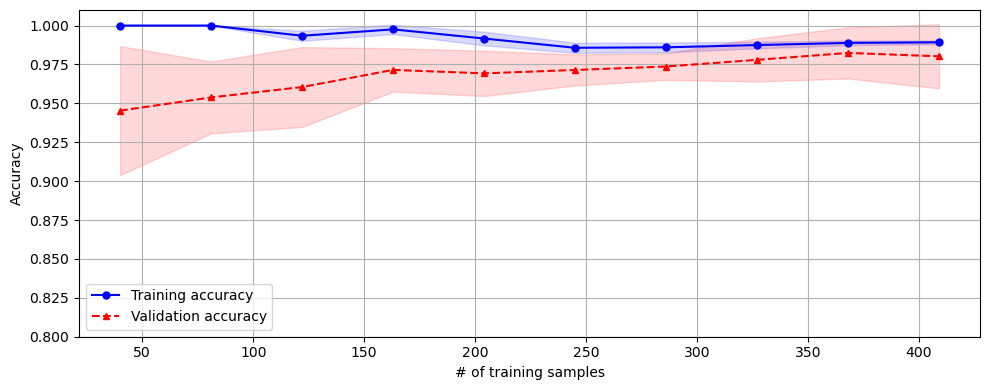

In [10]:
import matplotlib.pyplot as plt
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 4))
plt.plot(train_sizes, mean_train_scores, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, mean_train_scores + std_train_scores, mean_train_scores - std_train_scores, alpha=0.15, color='blue')
plt.plot(train_sizes, mean_test_scores, linestyle='--', color='red', marker='^', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, mean_test_scores + std_test_scores, mean_test_scores - std_test_scores, alpha=0.15, color='red')
plt.grid()
plt.legend(loc='best')
plt.xlabel('# of training samples')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.01])
plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import validation_curve
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores, test_scores = validation_curve(
    estimator=lr_pipe,
    X=x_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10,
    n_jobs=-1
)

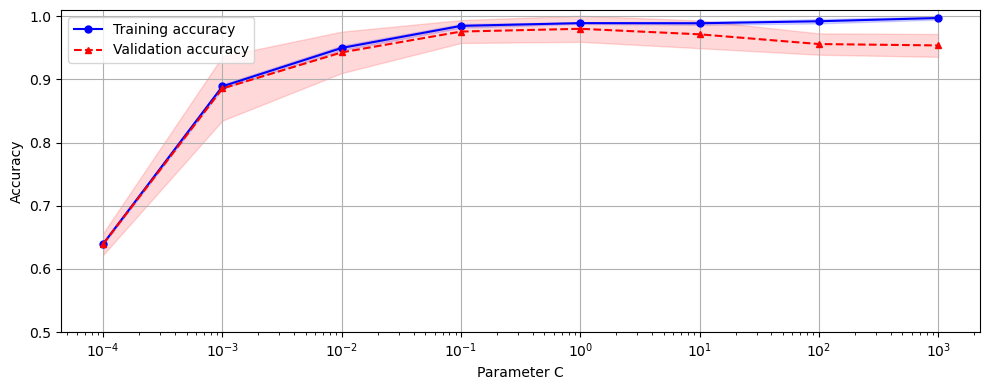

In [12]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 4))
plt.plot(param_range, mean_train_scores, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, mean_train_scores + std_train_scores, mean_train_scores - std_train_scores, alpha=0.15, color='blue')
plt.plot(param_range, mean_test_scores, linestyle='--', color='red', marker='^', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, mean_test_scores + std_test_scores, mean_test_scores - std_test_scores, alpha=0.15, color='red')
plt.grid()
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.tight_layout()
plt.show()

# Grid Search

Grid search is an exhaustive search method that investigates all possible combinations of parameter values. For more information, visit scikit-learn.org about [GridSearchCV API](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svc_pipe = make_pipeline(
    StandardScaler(),
    SVC(random_state=1)
)
C_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
gamma_range = [0.0001, 0.001]
param_grid = [
    {'svc__C': C_range, 'svc__kernel': ['linear']},
    {'svc__C': C_range, 'svc__gamma': gamma_range, 'svc__kernel': ['rbf'], 'svc__class_weight': ['balanced', None]}
]
gs = GridSearchCV(
    estimator=svc_pipe,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=10,
    verbose=3
)
gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
0.9846859903381642
{'svc__C': 100.0, 'svc__class_weight': None, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [16]:
best = gs.best_estimator_
print('Test accuracy: %.3f' % best.score(x_test, y_test))

Test accuracy: 0.974


# Randomized Search

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
C_dist = loguniform(1e-4, 1e4)
gamma_dist = loguniform(1e-4, 1e-3)
param_dist = [
    {'svc__C': C_dist, 'svc__kernel': ['linear']},
    {'svc__C': C_dist, 'svc__gamma': gamma_dist, 'svc__kernel': ['rbf'], 'svc__class_weight': ['balanced', None]}
]
rs = RandomizedSearchCV(
    estimator=svc_pipe,
    param_distributions=param_dist,
    n_iter=50,
    n_jobs=-1,
    cv=10,
    verbose=3,
    random_state=1
)
rs.fit(x_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
0.9846859903381642
{'svc__C': 832.0741228208968, 'svc__class_weight': None, 'svc__gamma': 0.00012163098152196437, 'svc__kernel': 'rbf'}


# Model Evaluation Metrics

Confusion matrix is a squared matrix that indicates the number of **True Positive** (TP), **True Negative** (TN), **False Positive** (FP) and **False Negative** (FN) samples.

In [21]:
from sklearn.metrics import confusion_matrix
svc_pipe.fit(x_train, y_train)
y_pred = svc_pipe.predict(x_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


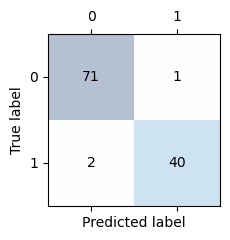

In [22]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(i, j, s=confmat[j, i], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

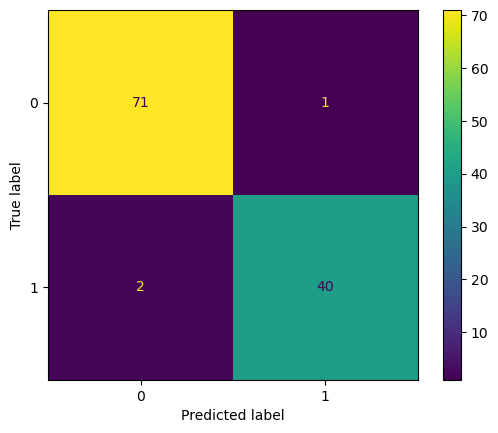

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svc_pipe, x_test, y_test)
plt.show()

Calculations for each metric are as follows:
- Accuarcy, $ACC = {{TP + TN}\over{FP + FN + TP + TN}}$
- False Positive Rate, $FPR = {FP\over{FP + TN}}$
- True Positive Rate, $TPR = {TP\over{FN + TP}}$
- Precision, $PRE = {TP\over{TP + FP}}$
- Recall, $REC = TPR = {TP\over{FN + TP}}$
- F1, $F1 = 2 {{PRE * REC}\over{PRE + REC}}$

In [24]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)
print('Accuracy score: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1 score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Accuracy score: 0.974
Precision score: 0.976
Recall score: 0.952
F1 score: 0.964


# ROC Curve

Quoting from scikit-learn.org about [Receiver Operating Characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics): "Receiver Operating Characteristic is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the TPR vs. FPR, at various threshold settings." In addition, visit [RocCurveDisplay class API](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) for more information about the RocCurveDisplay class.

Computing the area under the ROC curve (ROC AUC) can quantitatively evaluate the overall classification model performance.

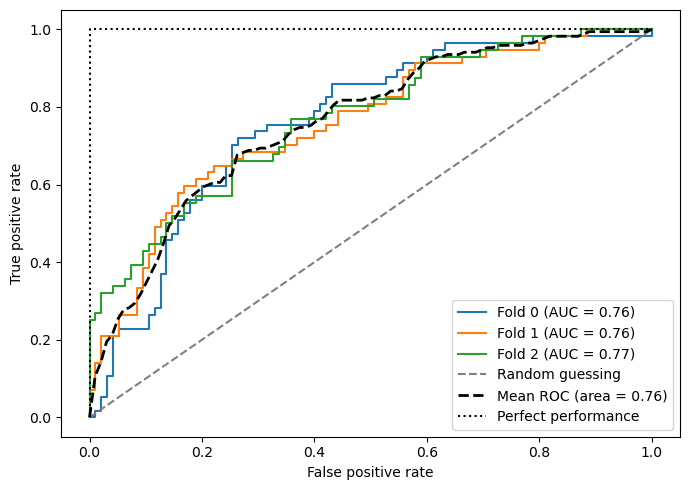

In [25]:
# ROC Curve and ROC AUC (Area Under Curve)
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from numpy import interp
roc_x = x_train[:, [4, 14]]
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(x_train, y_train)
fig, ax = plt.subplots(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
for i, (train, test) in enumerate(cv):
    lr_pipe.fit(roc_x[train], y_train[train])
    roc = RocCurveDisplay.from_estimator(lr_pipe, roc_x[test], y_train[test], name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc.fpr, roc.tpr)
    mean_tpr[0] = 0.0
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
mean_tpr /= 3
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, linestyle='--', color='black', label='Mean ROC (area = %.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.tight_layout()
plt.show()